In [1]:
# google drive
from google.colab import drive
drive.mount('/content/drive')
dirpath = "/content/drive/MyDrive/5053/"

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
import numpy as np
import math
import torch
 
# 数据的差分转换
def difference(data_set,interval=1):
    diff=list()
    for i in range(interval,len(data_set)):
        value=data_set[i]-data_set[i-interval]
        diff.append(value)
    return pd.Series(diff)
 
# 对预测的数据进行逆差分转换
def invert_difference(history,yhat,interval=1):
    return yhat+history[-interval]
 
# 将数据转换为监督学习集，移位后产生的NaN值补0
def timeseries_to_supervised(data,lag=1):
    df=pd.DataFrame(data)
    columns=[df.shift(i) for i in range(1,lag+1)]
    columns.append(df)
    df=pd.concat(columns,axis=1)
    df.fillna(0,inplace=True)
    return df
 
# 将数据缩放到[-1,1]之间
def scale(train,test):
    # 创建一个缩放器，将数据集中的数据缩放到[-1,1]的取值范围中
    scaler=MinMaxScaler(feature_range=(-1,1))
    # 使用数据来训练缩放器
    scaler=scaler.fit(train)
    # 使用缩放器来将训练集和测试集进行缩放
    train_scaled=scaler.transform(train)
    test_scaled=scaler.transform(test)
    return scaler,train_scaled,test_scaled
 
# 将预测值进行逆缩放，使用之前训练好的缩放器，x为一维数组，y为实数
def invert_scale(scaler,X,y):
    # 将X,y转换为一个list列表
    new_row=[x for x in X]+[y]
    # 将列表转换为数组
    array=np.array(new_row)
    # 将数组重构成一个形状为[1,2]的二维数组->[[10,12]]
    array=array.reshape(1,len(array))
    # 逆缩放输入的形状为[1,2]，输出形状也是如此
    invert=scaler.inverse_transform(array)
    # 只需要返回y值即可
    return invert[0,-1]
 
# 构建一个LSTM模型
def fit_lstm(train,batch_size,nb_epoch,neurons):
    # 将数据对中的x和y分开
    X,y=train[:,0:-1],train[:,-1]
    # 将2D数据拼接成3D数据，形状为[N*1*1]
    X=X.reshape(X.shape[0],1,X.shape[1])
 
    model=Sequential()
    model.add(LSTM(neurons,batch_input_shape=(batch_size,X.shape[1],X.shape[2]),stateful=True))
    model.add(Dense(1))
 
    model.compile(loss='mean_squared_error',optimizer='adam')
    for i in range(nb_epoch):
        # shuffle是不混淆数据顺序
        his=model.fit(X,y,batch_size=batch_size,verbose=1,shuffle=False)
        # 每训练完一次就重置一次网络状态，网络状态与网络权重不同
        model.reset_states()
    return model
 
# 开始单步预测
def forecast_lstm(model,batch_size,X):
    # 将形状为[1:]的，包含一个元素的一维数组X，转换形状为[1,1,1]的3D张量
    X=X.reshape(1,1,len(X))
    # 输出形状为1行一列的二维数组yhat
    yhat=model.predict(X,batch_size=batch_size)
    # 将yhat中的结果返回
    return yhat[0,0]

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler


def process(path):
    """
    pre-processing TRI data
    for train set (1997-2020): 1.eliminate extreme values; 2. standardization
    for test set (2020-2022): rolling window standardization
    """
    df = pd.read_csv(path)
    tri = df.tri.values
    split_node = df[df['timestamp'].str.contains('2019')].index[-1]
    train = tri[:split_node+1]
    test = tri[split_node+1:]
    train = process_extreme_MAD(train).reshape(-1, 1)
    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    test = rolling_standard(train.ravel(), test)
    return train, test
    
    
def process_extreme_MAD(array, n=3):
    """
    Deal with extreme values, use MAD method
    """
    mid = np.median(array)
    mid1 = np.median(np.abs(array - mid))
    maximum = mid + n * mid1
    minimum = mid - n * mid1
    return np.clip(array, minimum, maximum)
    

def rolling_standard(pre, cur, n=60):
    """
    rolling window standardization
    """
    new = np.concatenate([pre[-(n-1):], cur])
    df = pd.DataFrame(new)
    mean = df.rolling(n).apply(np.mean)
    std = df.rolling(n).apply(np.std)
    df1 = (df - mean) / std
    return df1[(n-1):].values
path = dirpath + 'AUD_v2.csv'
train,test = process(path)
training_set_scaled = train
testing_set_scaled = test

In [4]:
supervised=timeseries_to_supervised(training_set_scaled,1)
supervised_value=supervised.values

In [5]:
supervised0=timeseries_to_supervised(testing_set_scaled,1)
supervised0_value=supervised0.values

In [7]:
train = supervised_value
test = supervised0_value

In [8]:
train = train[1:,:]
test = test[1:,:]

555/555 [==============================] - 1s 945us/step
Test MSE: 0.8386434540669482


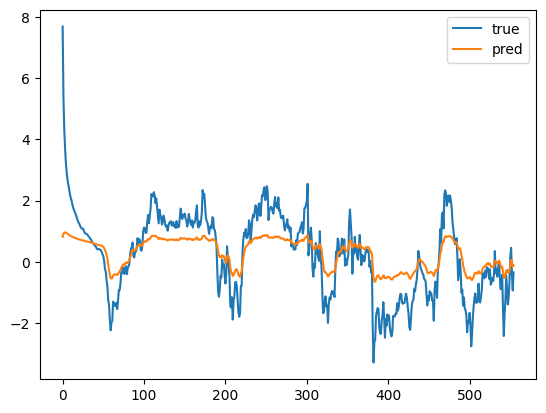

0.5595667870036101

In [ ]:
# train
lstm_model=fit_lstm(train,1,1,40)
# test
X,y=test[:,0:1],test[:,-1]
X=X.reshape(X.shape[0],1,X.shape[1])
yhat=lstm_model.predict(X,batch_size=1)
# plot
pred = yhat
raw_value = test[:,0]
pred = pred.reshape(1,-1)
pred = pred[0]
rmse=mean_squared_error(raw_value,pred)
print("Test MSE:",rmse)
plt.plot(raw_value)
plt.plot(pred)
plt.legend(['true','pred'])
plt.show()
# acc
a = pred[1:]
b = raw_value[:-1]
c = np.diff(raw_value)
out = np.logical_or(
                    np.logical_and((a-b < 0),(c < 0)), 
                    np.logical_and((a-b > 0),(c > 0))
                                             )
sum(out)/len(a)

555/555 [==============================] - 1s 1ms/step
Test MSE: 0.19767656812030163


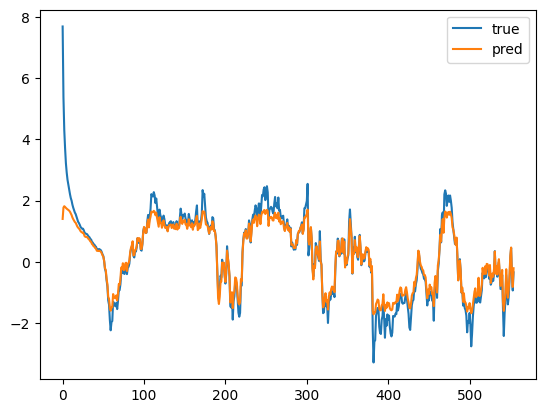

0.8122743682310469

In [ ]:
# train
lstm_model=fit_lstm(train,1,50,40)
# test
X,y=test[:,0:1],test[:,-1]
X=X.reshape(X.shape[0],1,X.shape[1])
yhat=lstm_model.predict(X,batch_size=1)
# plot
pred = yhat
raw_value = test[:,0]
pred = pred.reshape(1,-1)
pred = pred[0]
rmse=mean_squared_error(raw_value,pred)
print("Test MSE:",rmse)
plt.plot(raw_value)
plt.plot(pred)
plt.legend(['true','pred'])
plt.show()
# acc
a = pred[1:]
b = raw_value[:-1]
c = np.diff(raw_value)
out = np.logical_or(
                    np.logical_and((a-b < 0),(c < 0)), 
                    np.logical_and((a-b > 0),(c > 0))
                                             )
sum(out)/len(a)

555/555 [==============================] - 1s 995us/step
Test MSE: 0.2378626210039687


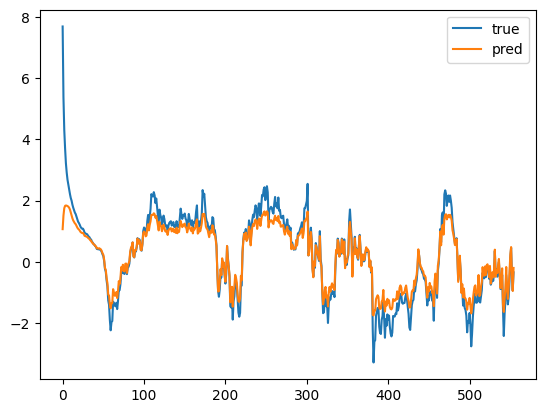

0.7527075812274369

In [ ]:
# train
lstm_model=fit_lstm(train,1,50,10)
# test
X,y=test[:,0:1],test[:,-1]
X=X.reshape(X.shape[0],1,X.shape[1])
yhat=lstm_model.predict(X,batch_size=1)
# plot
pred = yhat
raw_value = test[:,0]
pred = pred.reshape(1,-1)
pred = pred[0]
rmse=mean_squared_error(raw_value,pred)
print("Test MSE:",rmse)
plt.plot(raw_value)
plt.plot(pred)
plt.legend(['true','pred'])
plt.show()
# acc
a = pred[1:]
b = raw_value[:-1]
c = np.diff(raw_value)
out = np.logical_or(
                    np.logical_and((a-b < 0),(c < 0)), 
                    np.logical_and((a-b > 0),(c > 0))
                                             )
sum(out)/len(a)

555/555 [==============================] - 1s 978us/step
Test MSE: 0.2577183652434465


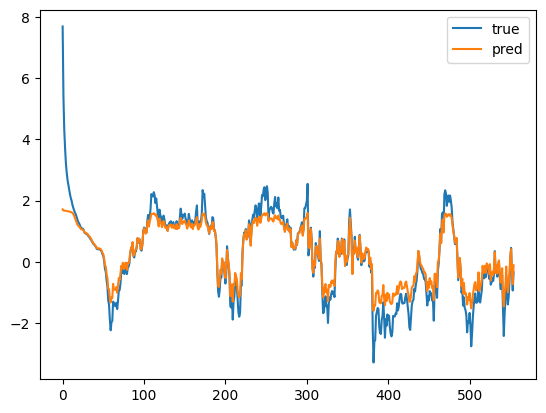

0.7563176895306859

In [ ]:
# train
lstm_model=fit_lstm(train,1,50,60)
# test
X,y=test[:,0:1],test[:,-1]
X=X.reshape(X.shape[0],1,X.shape[1])
yhat=lstm_model.predict(X,batch_size=1)
# plot
pred = yhat
raw_value = test[:,0]
pred = pred.reshape(1,-1)
pred = pred[0]
rmse=mean_squared_error(raw_value,pred)
print("Test MSE:",rmse)
plt.plot(raw_value)
plt.plot(pred)
plt.legend(['true','pred'])
plt.show()
# acc
a = pred[1:]
b = raw_value[:-1]
c = np.diff(raw_value)
out = np.logical_or(
                    np.logical_and((a-b < 0),(c < 0)), 
                    np.logical_and((a-b > 0),(c > 0))
                                             )
sum(out)/len(a)

555/555 [==============================] - 1s 1ms/step
Test MSE: 0.19962149157017145


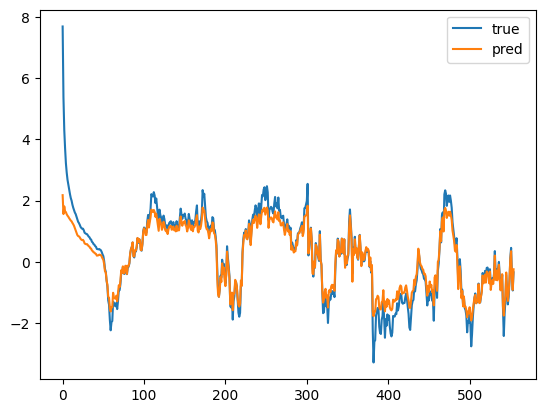

0.7924187725631769

In [ ]:
# train
lstm_model=fit_lstm(train,1,50,100)
# test
X,y=test[:,0:1],test[:,-1]
X=X.reshape(X.shape[0],1,X.shape[1])
yhat=lstm_model.predict(X,batch_size=1)
# plot
pred = yhat
raw_value = test[:,0]
pred = pred.reshape(1,-1)
pred = pred[0]
rmse=mean_squared_error(raw_value,pred)
print("Test MSE:",rmse)
plt.plot(raw_value)
plt.plot(pred)
plt.legend(['true','pred'])
plt.show()
# acc
a = pred[1:]
b = raw_value[:-1]
c = np.diff(raw_value)
out = np.logical_or(
                    np.logical_and((a-b < 0),(c < 0)), 
                    np.logical_and((a-b > 0),(c > 0))
                                             )
sum(out)/len(a)

555/555 [==============================] - 1s 1ms/step
Test MSE: 0.2322818728471518


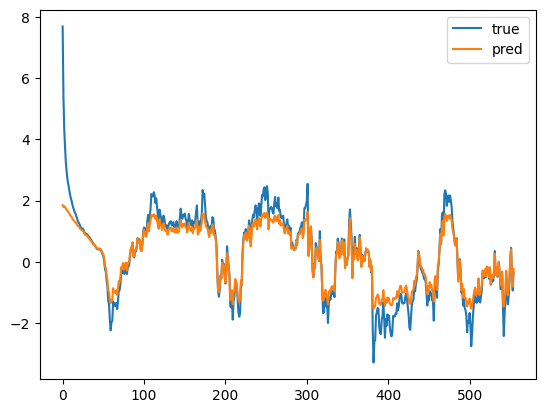

0.7509025270758123

In [ ]:
# train
lstm_model=fit_lstm(train,1,50,200)
# test
X,y=test[:,0:1],test[:,-1]
X=X.reshape(X.shape[0],1,X.shape[1])
yhat=lstm_model.predict(X,batch_size=1)
# plot
pred = yhat
raw_value = test[:,0]
pred = pred.reshape(1,-1)
pred = pred[0]
rmse=mean_squared_error(raw_value,pred)
print("Test MSE:",rmse)
plt.plot(raw_value)
plt.plot(pred)
plt.legend(['true','pred'])
plt.show()
# acc
a = pred[1:]
b = raw_value[:-1]
c = np.diff(raw_value)
out = np.logical_or(
                    np.logical_and((a-b < 0),(c < 0)), 
                    np.logical_and((a-b > 0),(c > 0))
                                             )
sum(out)/len(a)

In [9]:
# train
lstm_model=fit_lstm(train,1,50,40)

5944/5944 [==============================] - 15s 2ms/step - loss: 5.2217e-04


In [10]:
# test
X,y=test[:,0:1],test[:,-1]
X=X.reshape(X.shape[0],1,X.shape[1])
yhat=lstm_model.predict(X,batch_size=1)

555/555 [==============================] - 4s 6ms/step


Test MSE: 0.2552867296471461


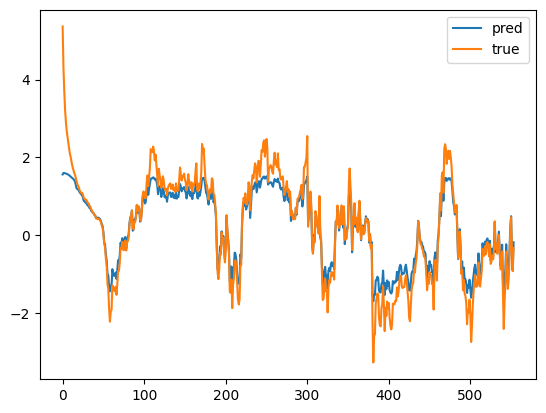

In [18]:
# plot
pred = yhat
raw_value = test[:,0]
pred = pred.reshape(1,-1)
pred = pred[0]
rmse=mean_squared_error(raw_value,pred)
print("Test MSE:",rmse)
plt.plot(pred[1:], label="pred")
plt.plot(raw_value[1:], label="true")
plt.legend()
plt.show()